In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [2]:
import iris
import iris.quickplot as qplt

## First open data in Iris for regridding

In [3]:
cpm_cubes = iris.load("../../../../data/2.2km/rcp85/01/pr/*.nc")
gcm_cubes = iris.load("../../../../data/60km/rcp85/01/*/day/*.nc").extract(iris.Constraint(time=lambda cell: cftime.Datetime360Day(1980, 12, 1, 12, 0, 0, 0) <= cell.point <= cftime.Datetime360Day(1981, 11, 30, 12, 0, 0, 0)))

In [4]:
cpm_cubes

Lwe Precipitation Rate (mm/day),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [5]:
gcm_cubes

Air Pressure At Sea Level (hPa),ensemble_member,time,projection_y_coordinate,projection_x_coordinate
Shape,1,360,23,17
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


GCM and CPM data use different coordinate systems. GCM is on the OSGB projection, while CPM is on a rotated pole system.

In [8]:
gcm_cubes[1].coord_system()

TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))

In [9]:
cpm_cubes[0].coord_system()

RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))

## Re-grid GCM data 
So that it uses the same co-ordinate system AND have a simple way to match the GCM values to the CPM values (have same co-ordinates).

NB this is not particularly fast on this laptop and is quite memory intensive - turns a small 60km dataset set into a much large 2.2km dataset but without any actually added data. Could look to do this on the fly instead.
Iris will make a lazy cube so then re-processes it each time of asking (slow!). For time being saving the output to disk. Also I prefer working with xarray so this approach allows it.

In [10]:
rp_gcm_cube = gcm_cubes[1].regrid(cpm_cubes[0], iris.analysis.Nearest())
iris.save(rp_gcm_cube, '../../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_nn_regrid_19801201-19811130.nc')

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [12]:
rp_gcm_cube = gcm_cubes[1].regrid(cpm_cubes[0], iris.analysis.Linear())
iris.save(rp_gcm_cube, '../../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_linear_regrid_19801201-19811130.nc')

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


## Re-open datasets in xarray

Mainly because that's what I prefer to work with!

In [50]:
pr = xr.open_mfdataset("../../../../data/2.2km/rcp85/01/pr/*.nc")
gcmdata = xr.open_mfdataset("../../../../data/60km/rcp85/01/*/day/*.nc").isel(time=slice(360,720))
nn_regridded_gcmdata = xr.open_dataset('../../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_nn_regrid_19801201-19811130.nc')
linear_regridded_gcmdata = xr.open_dataset('../../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_linear_regrid_19801201-19811130.nc')

In [87]:
wettest_itime = gcmdata.sum(dim=["projection_y_coordinate", "projection_x_coordinate"]).pr.argmax(dim="time").values
wettest_time = gcmdata.time[wettest_itime[0]].values

pr_single_day = pr.sel(ensemble_member=1, time=wettest_time)
gcm_single_day = gcmdata.sel(ensemble_member=1, time=wettest_time)
nn_regridded_gcm_single_day = nn_regridded_gcmdata.sel(ensemble_member=1, time=wettest_time)
linear_regridded_gcm_single_day = linear_regridded_gcmdata.sel(ensemble_member=1, time=wettest_time)

In [88]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


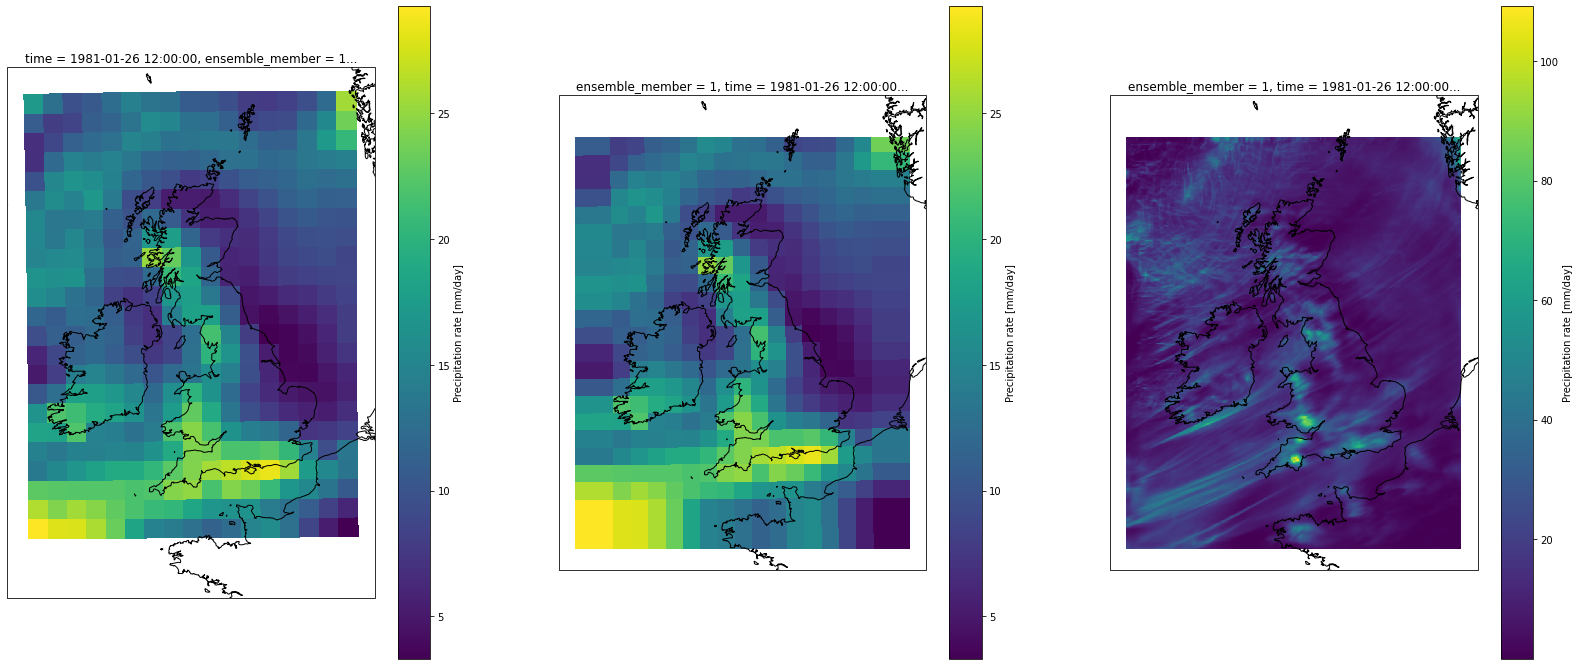

In [89]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(28, 12), sharey=True, subplot_kw={'projection': cp_model_rotated_pole})

gcm_single_day.pr.plot(ax=ax1, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)
nn_regridded_gcm_single_day.pr.plot(ax=ax2, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
pr_single_day.pr.plot.pcolormesh(ax=ax3, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

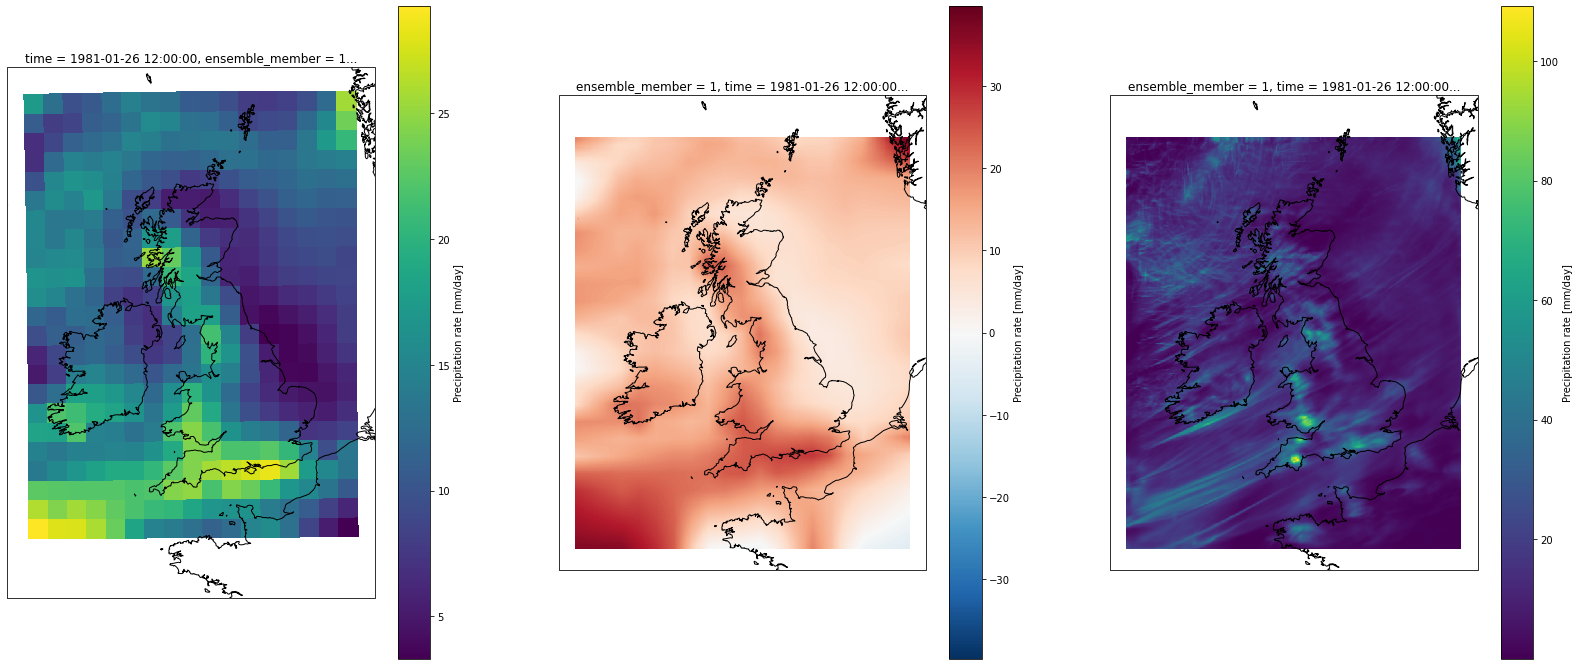

In [90]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(28, 12), sharey=True, subplot_kw={'projection': cp_model_rotated_pole})

gcm_single_day.pr.plot(ax=ax1, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)
linear_regridded_gcm_single_day.pr.plot(ax=ax2, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
pr_single_day.pr.plot.pcolormesh(ax=ax3, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

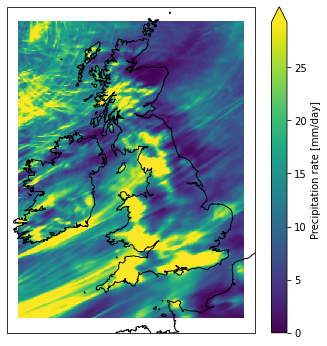

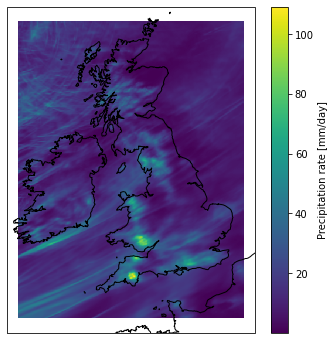

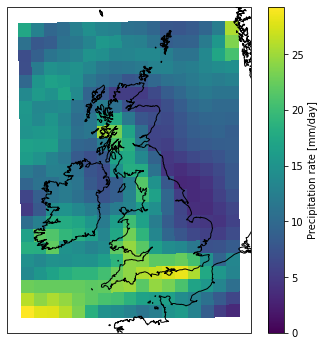

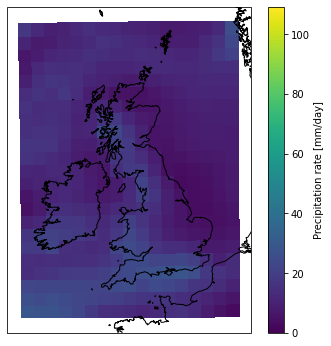

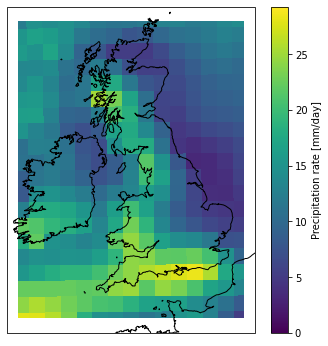

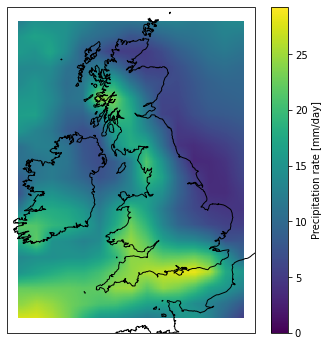

In [98]:
min_value = 0# gcm_single_day.pr.values.min()  # Lowest value
max_value = gcm_single_day.pr.values.max()  # Highest value

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

pr_single_day.isel(grid_latitude=slice(50, -50), grid_longitude=slice(50, -50)).pr.plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole, vmin=min_value, vmax=max_value)
# title = u"%s — %s" % (pr_single_day.pr.long_name, str(pr_single_day.time[0].values)[:19])
ax.set_title("")
fig.savefig("cpm-snapshot-1981-01-26-gcm-colorscale.png")

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

pr_single_day.isel(grid_latitude=slice(50, -50), grid_longitude=slice(50, -50)).pr.plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)#, vmin=min_value, vmax=max_value)
# title = u"%s — %s" % (pr_single_day.pr.long_name, str(pr_single_day.time[0].values)[:19])
ax.set_title("")
fig.savefig("cpm-snapshot-1981-01-26.png")


fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
gcm_single_day.pr.plot(ax=ax, x='longitude', y='latitude', add_colorbar=True, transform=platecarree, vmin=min_value, vmax=max_value)
ax.set_title("")
fig.savefig("gcm-snapshot-1981-01-26.png")

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
gcm_single_day.pr.plot(ax=ax, x='longitude', y='latitude', add_colorbar=True, transform=platecarree, vmin=min_value, vmax=pr_single_day.pr.values.max())
ax.set_title("")
fig.savefig("gcm-snapshot-1981-01-26-cpm-colorscale.png")

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
nn_regridded_gcm_single_day.isel(grid_latitude=slice(50, -50), grid_longitude=slice(50, -50)).pr.plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole, vmin=min_value, vmax=max_value)
ax.set_title("")
fig.savefig("nn-regridded-gcm-snapshot-1981-01-26.png")

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
linear_regridded_gcm_single_day.isel(grid_latitude=slice(50, -50), grid_longitude=slice(50, -50)).pr.plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole, vmin=min_value, vmax=max_value)
ax.set_title("")
fig.savefig("linear-regridded-gcm-snapshot-1981-01-26.png")

## Selecting and assigning to subsets

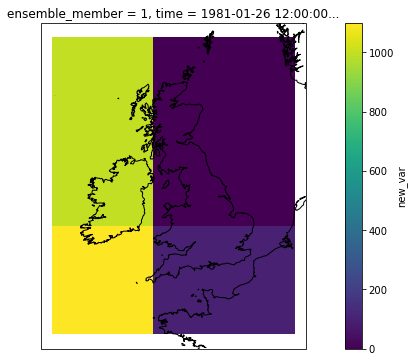

In [92]:
pr_single_day['new_var'] = xr.full_like(pr_single_day.pr, fill_value=0)
pr_single_day['new_var'] = xr.where(pr_single_day['new_var'].coords["grid_latitude"] < 0, 100, pr_single_day["new_var"])
pr_single_day['new_var'][dict(grid_longitude=slice(200))] += 1000

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(pr_single_day['new_var'], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


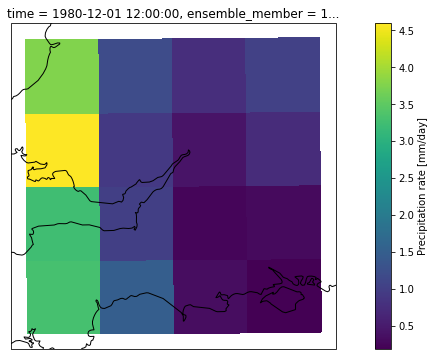

In [178]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
                       
da = gcm_single_day.pr[3:7, 8:12]
xplt.plot(da, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

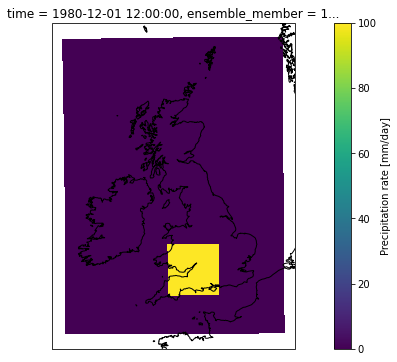

In [171]:
gcm_single_day['new_var'] = xr.full_like(gcm_single_day.pr, fill_value=0)
gcm_single_day['new_var'][3:7, 8:12] = 100

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(gcm_single_day['new_var'], x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


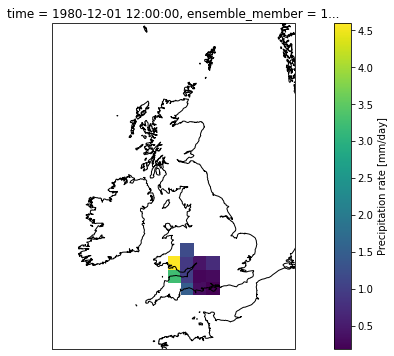

In [194]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
mask = (
    (gcm_single_day.latitude < 52.3276151188887) & (gcm_single_day.latitude > 50.694524325907075) &
    (gcm_single_day.longitude < -1.2662661736262122) & (gcm_single_day.longitude > -3.9072194147630217)
)
da = gcm_single_day.where(mask).pr
                       

xplt.plot(da, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

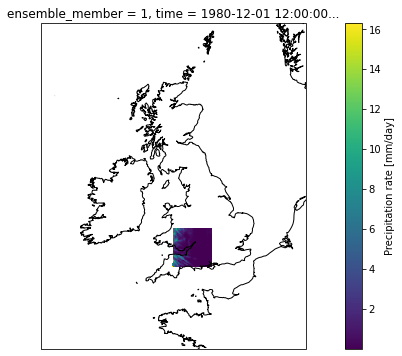

In [193]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
mask = (
    (pr_single_day.latitude < 52.3276151188887) & (pr_single_day.latitude > 50.694524325907075) &
    (pr_single_day.longitude < -1.2662661736262122) & (pr_single_day.longitude > -3.9072194147630217)
)
da = pr_single_day.where(mask).pr
                       

xplt.plot(da, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

In [4]:
gcmcube = gcm_cubes[0]

In [22]:
gcmcube.coords()[1].points

array([ 85692.,  85716.,  85740., ..., 172020., 172044., 172068.])

In [29]:
gcmcube.extract(iris.Constraint(time=lambda cell: cftime.Datetime360Day(1980, 12, 1, 12, 0, 0, 0) <= cell.point <= cftime.Datetime360Day(1981, 11, 30, 12, 0, 0, 0)))

Air Pressure At Sea Level (hPa),ensemble_member,time,projection_y_coordinate,projection_x_coordinate
Shape,1,360,23,17
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [31]:
import os

In [32]:
os.makedirs?

Signature: os.makedirs(name, mode=511, exist_ok=False)
Docstring:
makedirs(name [, mode=0o777][, exist_ok=False])

Super-mkdir; create a leaf directory and all intermediate ones.  Works like
mkdir, except that any intermediate path segment (not just the rightmost)
will be created if it does not exist. If the target directory already
exists, raise an OSError if exist_ok is False. Otherwise no exception is
raised.  This is recursive.
File:      ~/anaconda3/envs/downscaling/lib/python3.9/os.py
Type:      function


In [7]:
(rpgcm_cube, _) = iris.analysis.cartography.project(gcm_cubes[2], cpm_cubes[0].coord_system())

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn(
/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/analysis/cartography.py:821: UserWarning: Discarding coordinates that share dimensions with latitude and longitude: ['projection_x_coordinate', 'projection_y_coordinate']
  warnings.warn(


(<iris 'Cube' of lwe_precipitation_rate / (mm/day) (ensemble_member: 1; time: 3600; projection_y_coordinate: 23; projection_x_coordinate: 17)>,
 [-180, 180, -90, 90])

In [16]:
rpgcm_cube.coords()[2]

DimCoord(array([-8.60869565e+01, -7.82608696e+01, -7.04347826e+01, -6.26086957e+01,
       -5.47826087e+01, -4.69565217e+01, -3.91304348e+01, -3.13043478e+01,
       -2.34782609e+01, -1.56521739e+01, -7.82608696e+00, -4.88498131e-15,
        7.82608696e+00,  1.56521739e+01,  2.34782609e+01,  3.13043478e+01,
        3.91304348e+01,  4.69565217e+01,  5.47826087e+01,  6.26086957e+01,
        7.04347826e+01,  7.82608696e+01,  8.60869565e+01]), standard_name='projection_y_coordinate', units=Unit('m'), coord_system=RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0)))

In [17]:
cpm_cubes[0].coords()[2]

DimCoord(array([-4.68274879e+00, -4.64674902e+00, -4.61074924e+00, -4.57474899e+00,
       -4.53874922e+00, -4.50274897e+00, -4.46674919e+00, -4.43074894e+00,
       -4.39474916e+00, -4.35874891e+00, -4.32274914e+00, -4.28674889e+00,
       -4.25074911e+00, -4.21474886e+00, -4.17997265e+00, -4.14637804e+00,
       -4.11392498e+00, -4.08257484e+00, -4.05228996e+00, -4.02303457e+00,
       -3.99477363e+00, -3.96747279e+00, -3.94109988e+00, -3.91562319e+00,
       -3.89101243e+00, -3.86723804e+00, -3.84427142e+00, -3.82208562e+00,
       -3.80065370e+00, -3.77994990e+00, -3.75994992e+00, -3.73994994e+00,
       -3.71994996e+00, -3.69994998e+00, -3.67995000e+00, -3.65995002e+00,
       -3.63995004e+00, -3.61995006e+00, -3.59995008e+00, -3.57995009e+00,
       -3.55995011e+00, -3.53994989e+00, -3.51994991e+00, -3.49994993e+00,
       -3.47994995e+00, -3.45994997e+00, -3.43994999e+00, -3.41995001e+00,
       -3.39995003e+00, -3.37995005e+00, -3.35995007e+00, -3.33995008e+00,
       -3.319950